# Write and Registration Benchmarks

These benchmarks were originally run on an early 2015 MacBook Pro with a 2.7 GHz dual-core i5 processor and 8GB of memory. All molecules are written into a data directory stored locally via `--dbpath`.

They make use of molecules found in the data folder. 

Last updated: 8/24/20 by Christopher Zou

## Setup Work
### Imports

In [1]:
from mongordkit.Database import write, registration
from rdkit import Chem
import rdkit
import numpy as np
import time
import pymongo
import mongomock
import matplotlib
import matplotlib.pyplot as plt

### Database Setup
Here we set up a database called `test` that will hold our molecules. We will construct a collection called `molecules_write_testing` to benchmark the speed of writing to a collection.

In [2]:
# Initialize the client that will connect to the database.
client = pymongo.MongoClient()
db = client.test
db.molecules_write_testing.drop()

### Defining Some Useful Variables

In [3]:
hash_functions = registration.HASH_FUNCTIONS
first_200_mols = '../../data/test_data/first_200.props.sdf'
chembl = '../../../chembl_27.sdf'

# Disable RDLogger to reduce system output.
rdkit.RDLogger.DisableLog('rdApp.*')

## Benchmarking Write

We want to know the performance of `write.WriteFromSDF`. To find out, let's write the first 1000-10000 (incrementing by 1000 every time) molecules of a ChEMBL dataset using a scheme that contains all 23 available hashes and take median write times:

In [ ]:
repetitions = 5
scheme = registration.MolDocScheme()
scheme.add_all_hashes()
times = []
limits = [1000 + (i * 1000) for i in range(11)]
for number in limits:
    temp_times = []
    print(f'testing {number}')
    for i in range(repetitions):
        mol_collection = db.molecules_write_testing
        start = time.time()
        write.WriteFromSDF(mol_collection, chembl, scheme, limit=number)
        end = time.time()
        duration = end - start
        mol_collection.drop()
        temp_times.append(duration)
    times.append([number, np.mean(temp_times)])

testing 1000
populating mongodb collection with compounds from SDF...
1000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
1000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
1000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
1000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
1000 molecules successfully imported
0 duplicates skipped
testing 2000
populating mongodb collection with compounds from SDF...
2000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
2000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF...
2000 molecules successfully imported
0 duplicates skipped
populating mongodb collection with compounds from SDF.

[[2000, 14.187205600738526],
 [2100, 14.940004205703735],
 [2200, 15.965514373779296],
 [2300, 16.910987186431885],
 [2400, 23.27452983856201],
 [2500, 21.29524955749512],
 [2600, 23.414347171783447],
 [2700, 25.251486158370973],
 [2800, 28.250892400741577],
 [2900, 28.316519117355348],
 [3000, 32.57432060241699]]

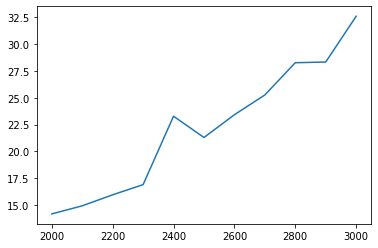

In [17]:
x_values = [i[0] for i in times]
y_values = [i[1] for i in times]
plt.plot(x_values, y_values)
times

Let's also divide each mean value by the number of molecules written to get a measure of how long it takes to write each molecule:

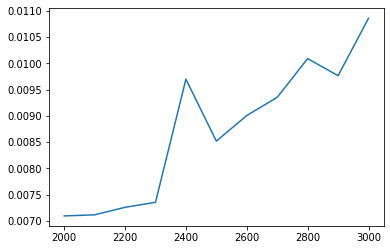

In [20]:
time_per_molecule = []
for i in range(times):
    time_per_molecule.append(y_values[i] / x_values[i])
        
plt.plot(x_values, time_per_molecule)

The amount of time required to insert each molecule appears to stay relatively constant between 0.02 and 0.025 seconds; 

## Breaking Down Write Times
### Hashes
`mongordkit.registration` provides (as of time of writing) 23 different molecular hash options. Calculating all of these hash options when writing molecules into a database results in extremely long write times. Here, we calculate the median time required to calculate each hash for the first 200 molecules in a ChEMBL database. 

In [4]:
median_times = []

for key in hash_functions: 
    times = []
    for rdmol in Chem.ForwardSDMolSupplier(first_200_mols):
        start = time.time()
        _ = hash_functions[key](rdmol)
        end = time.time()
        times.append(end - start)
    median_times.append([key, np.median(times)])

<BarContainer object of 23 artists>

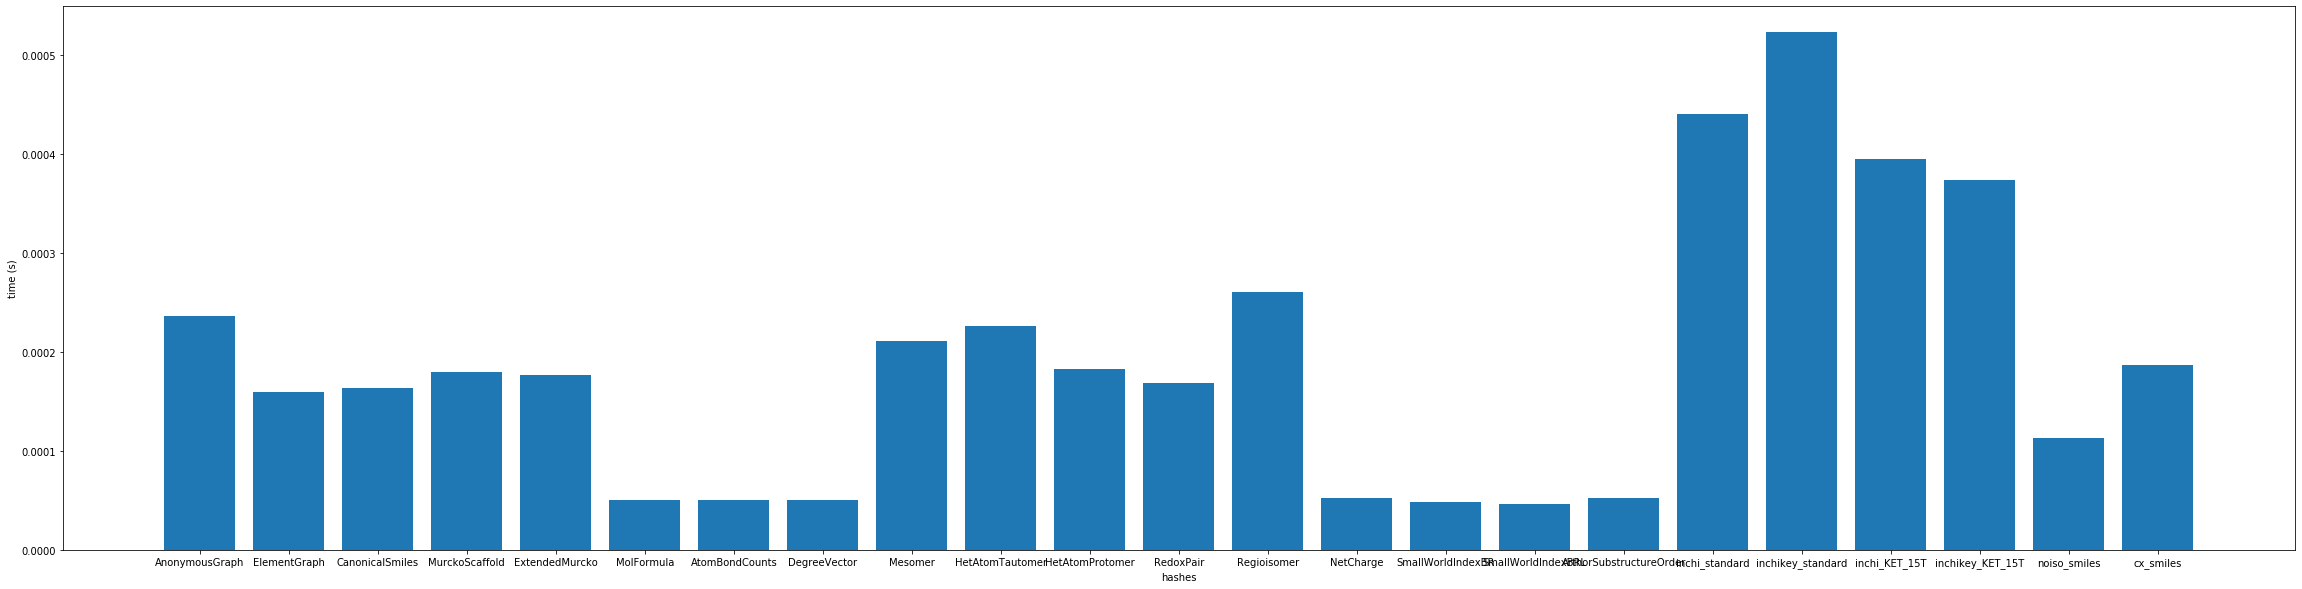

In [5]:
fig = plt.figure(figsize=(40, 10))
x_list = [v[0] for v in median_times]
y_list = [v[1] for v in median_times]
plt.xlabel('hashes')
plt.ylabel('time (s)')
plt.bar(x_list, y_list)

It is evident that some of the hashes take significantly longer (those with the inchikeys being almost eight times as expensive as MolFormula or DegreeVector. With this in mind, let's take a look at how long it takes to generate a mol document. 

### MolDocuments
By default, `mongordkit.registration` includes only `CanonicalSmiles` and `inchikey_standard` in the hashes it generates. Let's look at time to generate mol documents for the first 200 mols in a ChEMBL dataset from above for this default scheme:

In [6]:
scheme = registration.MolDocScheme()
times = []
for rdmol in Chem.ForwardSDMolSupplier(first_200_mols):
    start = time.time()
    _ = scheme.generate_mol_doc(rdmol)
    end = time.time()
    times.append(end - start)
print(f"Median required time: {np.median(times)}, Mean required time: {np.mean(times)}")

Median required time: 0.0010679960250854492, Mean required time: 0.0011445283889770508


What if we add all the hashes back in?

In [7]:
scheme.add_all_hashes()
times = []
for rdmol in Chem.ForwardSDMolSupplier(first_200_mols):
    start = time.time()
    _ = scheme.generate_mol_doc(rdmol)
    end = time.time()
    times.append(end - start)
print(f"Median required time: {np.median(times)}, Mean required time: {np.mean(times)}")

Median required time: 0.0047119855880737305, Mean required time: 0.00495597243309021


Adding all the hashes increases the required time by a factor of between 4 and 5. However, this is still a negligible amount (around 5%) of time compared to the time that it takes to actually write the molecule into the database from above. In fact, the total time required to generate all of these mol documents for a million molecules would be less than two hours. These benchmarks were run because writing a million molecules had taken more than three days. 

Evidently, most of the work happens in the insertion step. 